In [41]:
import pandas as pd 
import numpy as np 
import re 
import multiprocessing
from unidecode import unidecode
import os 
import tensorflow as tf 
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D,Conv2D,MaxPool1D
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
data=pd.read_csv('train1.csv')
data.head()

,ID,Sentence1,Sentence2,Class
0,0,"But instead of returning to heaven , Annie dec...","But instead of returning to Heaven , Chris cho...",0
1,1,"In 2016 , Bacardi announced new branding and p...","In 2016 , Bacardi announced new branding and p...",0
2,2,Kweku Baako Jnr had four children . One of the...,"Baako had four children , one of whom was Kwek...",0
3,3,"As with the Navy , the Army has a single-track...","Like the army , the Navy has a single-track sy...",0
4,4,Sissi units have fewer crew served weapons and...,Sissi units have more weapons served by the cr...,0


<Axes: xlabel='Class', ylabel='count'>

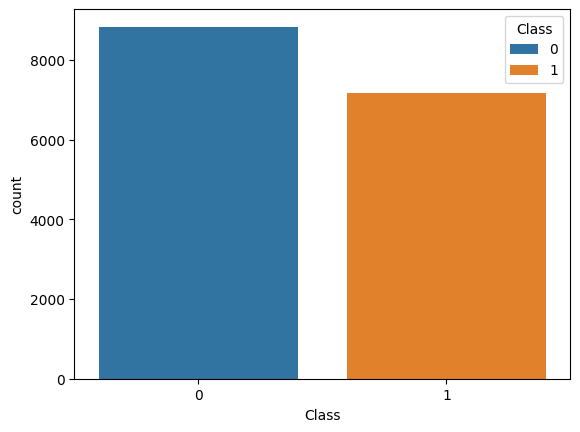

In [3]:
sns.countplot(x='Class', data=data,hue='Class')

In [4]:
data.shape

(16000, 4)

In [5]:
data.isnull().sum()

ID           0
Sentence1    0
Sentence2    0
Class        0
dtype: int64

In [6]:
#preprocess data 

def preprocess_text(text):
    #remove URLs
    text=re.sub(r'http\S+', '', text)
    text=re.sub(r'\[|\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\d', '', text)
    text = re.sub('[“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('[^A-Za-z0-9\s]', '', text)
     
    #Tokenization
    tokens=word_tokenize(text)
    
    #Lowercasing 
    tokens_lower=[token.lower() for token in tokens]
    
    #Removing punctuation 
    tokens_no_punct=[token for token in tokens_lower if token not in string.punctuation ]
    
    #Removing stopwords
    stop_words=set(stopwords.words('english'))
    tokens_no_stopwords=[token for token in tokens_no_punct if token not in stop_words]
    
    #stemming 
    porter=PorterStemmer()
    tokens_stemmed=[porter.stem(token) for token in tokens_no_stopwords]
    
    #lemmatization
    lemmatizer=WordNetLemmatizer()
    tokens_lemmatized=[lemmatizer.lemmatize(token) for token in tokens_no_stopwords]
    
    return tokens_lemmatized

In [13]:
data['Sentence1']=data['Sentence1'].apply(lambda text: preprocess_text(text))
data['Sentence1']=data['Sentence1'].apply(lambda x:' '.join(x))
data['Sentence2']=data['Sentence2'].apply(lambda text: preprocess_text(text))
data['Sentence2']=data['Sentence2'].apply(lambda x:' '.join(x))

In [14]:
data.head()

,ID,Sentence1,Sentence2,Class
0,0,instead returning heaven annie decided join ch...,instead returning heaven chris chooses join an...,0
1,1,bacardi announced new branding plan sell versi...,bacardi announced new branding plan sell versi...,0
2,2,kweku baako jnr four child one baako journalis...,baako four child one kweku baako jnr journalis...,0
3,3,navy army singletrack system officer navy comm...,like army navy singletrack system officer navy...,0
4,4,sissi unit fewer crew served weapon sniper rif...,sissi unit weapon served crew fewer sniper rif...,0


In [15]:
train_size=int(len(data)*0.8)
train_data=data[:train_size]
test_data=data[train_size:]


In [16]:
#Tokenize the text data 
tokenizer=Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['Sentence1'].astype(str)+' '+train_data['Sentence2'].astype(str))


X_train=tokenizer.texts_to_sequences(train_data['Sentence1'].astype(str)+' '+train_data['Sentence2'].astype(str))
X_train=pad_sequences(X_train,maxlen=100)


X_test=tokenizer.texts_to_sequences(test_data['Sentence1'].astype(str)+' '+test_data['Sentence2'].astype(str))
X_test=pad_sequences(X_test,maxlen=100)



In [17]:
# Model creation 
with tf.device('/gpu:0'):
    
    model = Sequential()
    model.add(Embedding(5000, 128, input_length=100))
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    model.fit(X_train, train_data['Class'], batch_size=64,epochs=10,validation_data=(X_test, test_data['Class']))

c:\Users\ismai\anaconda3\envs\env_python3.9\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 143ms/step - accuracy: 0.5472 - loss: 0.6896 - val_accuracy: 0.5603 - val_loss: 0.6855
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - accuracy: 0.6270 - loss: 0.6464 - val_accuracy: 0.5378 - val_loss: 0.7007
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - accuracy: 0.7243 - loss: 0.5547 - val_accuracy: 0.5337 - val_loss: 0.7687
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 143ms/step - accuracy: 0.7652 - loss: 0.4869 - val_accuracy: 0.5231 - val_loss: 0.8484
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 150ms/step - accuracy: 0.8065 - loss: 0.4113 - val_accuracy: 0.5228 - val_loss: 0.9844
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 151ms/step - accuracy: 0.8438 - loss: 0.3417 - val_accuracy: 0.5078 - val_loss: 1.1124
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 145ms/step - accuracy: 0.8733 - loss: 0.2866 - val_accuracy: 0.5100 - val_loss: 1.2974
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 143ms/step - accuracy: 0.8936 - loss: 0

In [18]:
loss, accuracy = model.evaluate(X_test, test_data['Class'])

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5145 - loss: 2.0643


# Logistic Regression 

In [19]:
train_data,test_data,train_labels,test_labels=train_test_split(data['Sentence1'].astype(str)+' '+data['Sentence2'].astype(str),data['Class'],
                                                               test_size=0.2,
                                                               random_state=42)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
train_data = vectorizer.fit_transform(train_data)
test_data = vectorizer.transform(test_data)

In [21]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(max_iter=1000)
model.fit(train_data,train_labels)
pred_lebales=model.predict(test_data)

In [22]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(pred_lebales,test_labels)
print('Model Accuracy',accuracy) 

Model Accuracy 0.51875


 # Naive Bayes Model 

In [23]:
from sklearn.naive_bayes import MultinomialNB
clf=MultinomialNB()
clf.fit(train_data,train_labels)
y_pred=clf.predict(test_data)
accuracy=accuracy_score(y_pred,test_labels)
print('Model Accuracy',accuracy)

Model Accuracy 0.52


# SVM

In [24]:
training_sentences=[]
testing_sentences=[]



train_sentences=train_data
train_labels=train_labels

for i in range(train_sentences.shape[0]):
    x=str(train_sentences[i])
    training_sentences.append(x)
training_sentences=np.array(training_sentences)



test_sentences=test_data
test_labels=test_labels

for i in range(test_sentences.shape[0]):
    x=str(test_sentences[i])
    testing_sentences.append(x)

testing_sentences=np.array(testing_sentences)


In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
vectorizer=CountVectorizer(lowercase=True)

kflod=StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
np.random.seed(1)
Pipeline_svm=make_pipeline(vectorizer,SVC(probability=True,kernel='linear',class_weight='balanced'))
grid_svm=GridSearchCV(Pipeline_svm,
                      param_grid={'svc__C':[0.01, 0.1,1]},
                      cv=kflod,
                      scoring='roc_auc',
                      verbose=1,
                      n_jobs=-1)


In [26]:
grid_svm.fit(training_sentences,train_labels)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            kernel='linear',
                                            probability=True))]),
             n_jobs=-1, param_grid={'svc__C': [0.01, 0.1, 1]},
             scoring='roc_auc', verbose=1)

In [27]:
from sklearn.metrics import accuracy_score,classification_report
accuracy=accuracy_score(test_labels,grid_svm.predict(testing_sentences))
print(accuracy)

0.5575


In [28]:
print(classification_report(test_labels,grid_svm.predict(testing_sentences)))

              precision    recall  f1-score   support

           0       0.56      0.91      0.69      1752
           1       0.55      0.13      0.21      1448

    accuracy                           0.56      3200
   macro avg       0.55      0.52      0.45      3200
weighted avg       0.55      0.56      0.47      3200



# Xgboost 

In [31]:
pip install xgboost

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 165.2 kB/s eta 0:10:04
   ---------------------------------------- 0.0/99.8 MB 219.4 kB/s eta 0:07:35
   ---------------------------------------- 0.1/99.8 MB 238.1 kB/s eta 0:06:59
   ---------------------------------------- 0.1/99.8 MB 368.6 kB/s eta 0:04:31
   ---------------------------------------- 0.1/99.8 MB 393.8 kB/s eta 0:04:13
   ---------------------------------------- 0.2/99.8 MB 595.3 kB/s eta 0:02:48
   ---------------------------------------- 0.3/99.8 MB 656.4 kB/s eta 0:02:32
   ---------------------------------------- 0.4/99.8 MB 843.6 kB/s eta 0:01:58
   ---------------------------------------- 0.5/99.8 MB 1.1 MB/s eta 0:01:32
   ---------------------------------------- 0.7/99.8 MB 1.3 MB/s eta 0:01:14
   -

In [32]:
from scipy.stats import uniform
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

param_dist={"learning_rate":uniform(0,2),
            "gamma":uniform(1,0.000001),
            "max_depth":range(1,50),
            "n_estimators":range(1,300),
            "min_child_weight":range(1,10),
            'n_jobs':range(1,5)
            }
rs=RandomizedSearchCV(XGBClassifier(),param_distributions=param_dist,n_iter=3)

In [33]:
model=Pipeline([('count',CountVectorizer()),
                ('tfidf',TfidfTransformer()),
                ('model',rs)])

In [34]:
model.fit(training_sentences,train_labels)

Pipeline(steps=[('count', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model',
                 RandomizedSearchCV(estimator=XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            gro...
                                                            random_state=None, ...),
                                    n_iter=3,
                                    param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A90E01C4C0>,
                                                         'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A96EEB6340>,
                                                         'max_depth': range(1, 50),
                                                         'min_child_weight': range(1, 10),
                                                         'n_estimators': range(1, 300),
                                                         'n_jobs': range(1, 5)}))])

In [35]:
predictions=model.predict(testing_sentences)
Accuracy=accuracy_score(test_labels,predictions)
print(Accuracy)

0.516875


In [36]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,predictions))

              precision    recall  f1-score   support

           0       0.55      0.63      0.59      1752
           1       0.46      0.38      0.41      1448

    accuracy                           0.52      3200
   macro avg       0.51      0.50      0.50      3200
weighted avg       0.51      0.52      0.51      3200



# KNN 

In [37]:
from sklearn.neighbors import KNeighborsClassifier
neig=np.arange(1,25)
train_accuracy = []
test_accuracy = []

for k in neig:
    knn = KNeighborsClassifier(n_neighbors=k)
    model = Pipeline([
        ('count', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('model', knn)
    ])
    
    model.fit(training_sentences, train_labels)
    train_accuracy.append(model.score(training_sentences, train_labels))
    test_accuracy.append(model.score(testing_sentences, test_labels))

best_k = np.argmax(test_accuracy) + 1
best_accuracy = np.max(test_accuracy)
print("Best accuracy is {} with k={}".format(best_accuracy, best_k))  



Best accuracy is 0.5540625 with k=6


In [38]:
print(classification_report(test_labels,model.predict(testing_sentences)))

              precision    recall  f1-score   support

           0       0.55      0.75      0.64      1752
           1       0.47      0.27      0.34      1448

    accuracy                           0.53      3200
   macro avg       0.51      0.51      0.49      3200
weighted avg       0.51      0.53      0.50      3200

